# Initial data exploration notebook

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error


In [114]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [218]:
# You can search you own location here: 
# https://www.ncei.noaa.gov/access/search/data-search/daily-summaries?stations=SP000008181
# Keep in mind that notebook expects only one station in file

data_url = 'https://www.ncei.noaa.gov/data/daily-summaries/access/SP000008181.csv'
df = pd.read_csv(data_url, low_memory=False)
data_tags = {'location_names': list(df.NAME.unique())}

In [208]:
df.head(2)

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES
0,SP000008181,1924-03-01,41.2928,2.0697,4.0,"BARCELONA AEROPUERTO, SP",0.0,",,E",NaN,NaN,120.0,",,E",10.0,",,E",NaN,NaN
1,SP000008181,1924-03-02,41.2928,2.0697,4.0,"BARCELONA AEROPUERTO, SP",0.0,",,E",NaN,NaN,120.0,",,E",20.0,",,E",NaN,NaN


In [219]:
df.dtypes

STATION             object
DATE                object
LATITUDE           float64
LONGITUDE          float64
ELEVATION          float64
NAME                object
PRCP               float64
PRCP_ATTRIBUTES     object
SNWD               float64
SNWD_ATTRIBUTES     object
TMAX               float64
TMAX_ATTRIBUTES     object
TMIN               float64
TMIN_ATTRIBUTES     object
TAVG               float64
TAVG_ATTRIBUTES     object
dtype: object

In [220]:
df.describe()

,LATITUDE,LONGITUDE,ELEVATION,PRCP,SNWD,TMAX,TMIN,TAVG
count,3.468700e+04,3.468700e+04,34687.0,34396.000000,2.000000,30738.000000,30556.000000,18814.000000
mean,4.129280e+01,2.069700e+00,4.0,15.543552,430.500000,203.847778,118.305963,160.422558
std,1.421106e-14,4.440956e-16,0.0,66.926721,580.534667,58.619100,60.532245,59.634623
min,4.129280e+01,2.069700e+00,4.0,0.000000,20.000000,0.000000,-80.000000,-21.000000
25%,4.129280e+01,2.069700e+00,4.0,0.000000,225.250000,156.000000,70.000000,112.000000
50%,4.129280e+01,2.069700e+00,4.0,0.000000,430.500000,200.000000,115.000000,154.000000
75%,4.129280e+01,2.069700e+00,4.0,0.000000,635.750000,254.000000,170.000000,213.000000
max,4.129280e+01,2.069700e+00,4.0,1867.000000,841.000000,374.000000,273.000000,303.000000


In [221]:
# prepare dataset
df = df[["DATE", "PRCP"]]
df["DATE"] = pd.to_datetime(df["DATE"])

In [210]:
df.dtypes

DATE    datetime64[ns]
PRCP           float64
dtype: object

<Axes: >

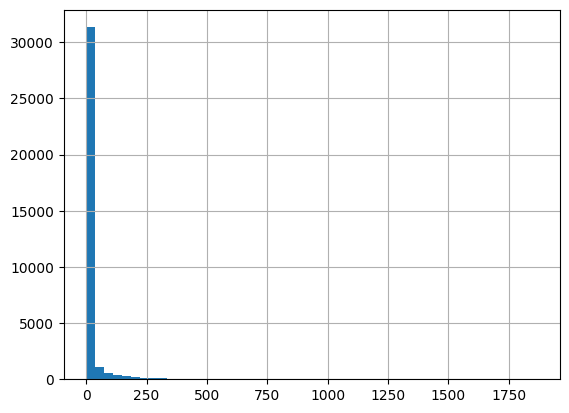

In [222]:
df.PRCP.hist(bins=50)

In [224]:
df.PRCP.max()

1867.0

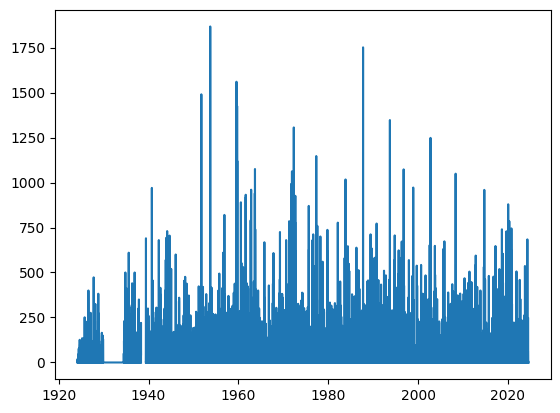

In [225]:
fig, ax = plt.subplots()
ax.plot(df["DATE"], df["PRCP"])

In [226]:
df2 = df[(df["DATE"] > "1935-01-01") & (df["DATE"] < "1940-01-01")]

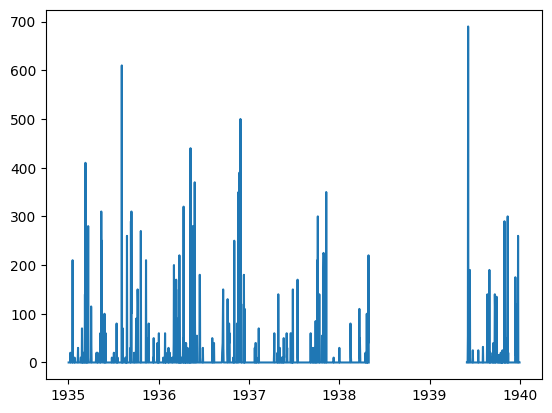

In [227]:
fig, ax = plt.subplots()
ax.plot(df2["DATE"], df2["PRCP"])

In [228]:
# There is big gap in data in 1939-1938 year
df_clean = df[(df["DATE"] > "1939-01-01")].copy()
display(len(df_clean))
df_clean.dropna(inplace=True)
display(len(df_clean))
df_clean

31095

31018

,DATE,PRCP
3592,1939-06-01,0.0
3593,1939-06-02,0.0
3594,1939-06-03,0.0
3595,1939-06-04,0.0
3596,1939-06-05,55.0
...,...,...
34668,2024-06-30,0.0
34670,2024-07-02,244.0
34671,2024-07-03,0.0
34681,2024-07-13,3.0


### Prepare data

In [241]:
# We will try to use lin reg to predict precipitation level
# based on previous values. It's very naive approach, but might be a good baseline.

df_clean['lag_1'] = df_clean['PRCP'].shift(1)
df_clean['lag_7'] = df_clean['PRCP'].shift(7)
df_clean['lag_30'] = df_clean['PRCP'].shift(30)
df_clean['lag_365'] = df_clean['PRCP'].shift(365)
df_clean['rolling_mean_7'] = df_clean['PRCP'].rolling(window=7).mean()
df_clean['rolling_std_7'] = df_clean['PRCP'].rolling(window=7).std()
df_clean['rolling_mean_30'] = df_clean['PRCP'].rolling(window=30).mean()
df_clean['rolling_std_30'] = df_clean['PRCP'].rolling(window=30).std()

# dropna againg
df_clean.dropna(inplace=True)

In [230]:
display(len(df_clean))
df_clean

30653

,DATE,PRCP,lag_1,lag_7,lag_30,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30
3957,1940-05-31,0.0,20.0,0.0,10.0,0.0,15.000000,31.754265,9.166667,22.708169
3958,1940-06-01,0.0,0.0,0.0,0.0,0.0,15.000000,31.754265,9.166667,22.708169
3959,1940-06-02,0.0,0.0,0.0,0.0,0.0,15.000000,31.754265,9.166667,22.708169
3960,1940-06-03,0.0,0.0,0.0,15.0,0.0,15.000000,31.754265,8.666667,22.740414
3961,1940-06-04,0.0,0.0,0.0,0.0,55.0,15.000000,31.754265,8.666667,22.740414
...,...,...,...,...,...,...,...,...,...,...
34668,2024-06-30,0.0,3.0,58.0,10.0,0.0,3.000000,3.651484,21.400000,57.573102
34670,2024-07-02,244.0,0.0,5.0,20.0,0.0,37.142857,91.284224,28.866667,70.466785
34671,2024-07-03,0.0,244.0,0.0,0.0,7.0,37.142857,91.284224,28.866667,70.466785
34681,2024-07-13,3.0,0.0,10.0,0.0,0.0,36.142857,91.668658,28.966667,70.426525


In [242]:
features = ['lag_1', 'lag_7', 'lag_30', 'lag_365', 
            'rolling_mean_7', 'rolling_std_7', 'rolling_mean_30', 'rolling_std_30']

# To test different lag sets change values here
# Year lag works ok and allows to predict up to 1 year in future
features = ['lag_365']

X = df_clean[features]
y = df_clean['PRCP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train.tail(10)


,lag_365
28561,213.0
28562,119.0
28563,0.0
28564,0.0
28565,0.0
28566,0.0
28567,4.0
28568,135.0
28569,0.0
28570,0.0


### Model

In [240]:
mlflow.set_experiment("weather-prediction-exp")
with mlflow.start_run():
    mlflow.set_tags(data_tags)
    
    # Train model
    model = LinearRegression()

    mlflow.log_params({'features': features})
    
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mlflow.log_metric("RMSE", rmse)
    mlflow.sklearn.log_model(model, artifact_path='models')
    
    print(f'RMSE: {rmse}')

RMSE: 61.84702451849965


/home/horhe/.cache/pypoetry/virtualenvs/drought-prediction-DZCTact4-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/horhe/.cache/pypoetry/virtualenvs/drought-prediction-DZCTact4-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [187]:
y_test.array

<NumpyExtensionArray>
[ 51.0,  94.0,   0.0,   0.0,   0.0,   0.0,   0.0,   4.0,   0.0,   1.0,
 ...
   0.0,  10.0,   3.0,   0.0,   3.0,   0.0, 244.0,   0.0,   3.0,   0.0]
Length: 5985, dtype: float64

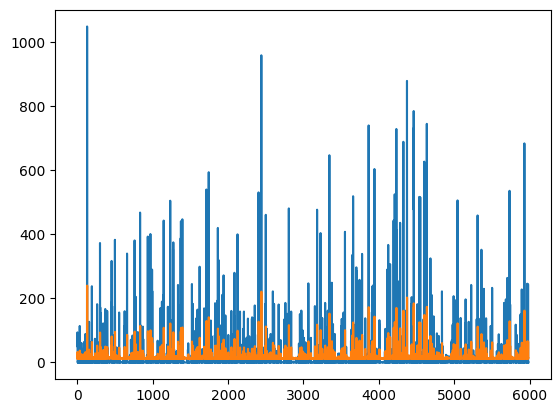

In [197]:
plt.plot(y_test.array) 
plt.plot(y_pred) 
plt.show()

In [243]:
data_url = 'https://www.ncei.noaa.gov/data/daily-summaries/access/SP000008181.csv'
my_df = pd.read_csv(data_url, low_memory=False)


In [254]:
retuired_columns = ["DATE", "NAME"]
display(list(my_df.columns))

set(retuired_columns).issubset(list(my_df.columns))

['STATION',
 'DATE',
 'LATITUDE',
 'LONGITUDE',
 'ELEVATION',
 'NAME',
 'PRCP',
 'PRCP_ATTRIBUTES',
 'SNWD',
 'SNWD_ATTRIBUTES',
 'TMAX',
 'TMAX_ATTRIBUTES',
 'TMIN',
 'TMIN_ATTRIBUTES',
 'TAVG',
 'TAVG_ATTRIBUTES']

True